# Install Dependencies

In [18]:
!pip install gensim
!pip install pyLDAvis

In [19]:
# General
import re
import numpy as np
import pandas as pd
import joblib

# Sklearn
from sklearn.cluster import KMeans 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Enable logging for gensim - optional
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [20]:
FILENAME = "../data/processed_data/clear_text.txt"
TEST_FILENAME = "../data/processed_data/test_folder/unreadable.txt"
STOPWORDS_FILENAME = "../data/stopwords.txt"

SEED = 42

In [21]:
with open(FILENAME, "r") as file:
    voc = [i.split() for i in file.read().strip().split("\n")]

with open(FILENAME, "r") as file:
    voc_sklearn = file.read().split("\n")
    
with open(TEST_FILENAME, "r") as file:
    test = file.read()

with open(STOPWORDS_FILENAME, "r") as file:
    stopwords = file.read().strip().split()

---

# Scikit-Learn Realization

In [22]:
cv = CountVectorizer()
dataset = cv.fit_transform(voc_sklearn)
dataset

<645x35454 sparse matrix of type '<class 'numpy.int64'>'
	with 279829 stored elements in Compressed Sparse Row format>

In [23]:
lda = LDA(
    n_components = 10,
    max_iter=30,
    n_jobs=-1,
    learning_method='batch',
    verbose=1,
    random_state=SEED
)
lda.fit(dataset)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30


LatentDirichletAllocation(max_iter=30, n_jobs=-1, random_state=42, verbose=1)

In [24]:
# Сохранение модели на диск
joblib.dump(lda, 'lda_model_sklearn.pkl')

# Загрузка модели с диска
loaded_lda = joblib.load('lda_model_sklearn.pkl')

In [25]:
class TopicModeler():
    '''
    Inteface object for CountVectorizer + LDA simple
    usage.
    '''
    
    def __init__(self, count_vect, lda):
        '''
        Args:
             count_vect - CountVectorizer object from sklearn.
             lda - LDA object from sklearn.
        '''
        
        self.lda = lda
        self.count_vect = count_vect
        self.count_vect.input = 'content'

    def __call__(self, text):
        '''
        Gives topics distribution for a given text
        Args:
             text - raw text via python string.
        returns: numpy array - topics distribution for a given text.
        '''
        
        vectorized = self.count_vect.transform([text])
        lda_topics = self.lda.transform(vectorized)
        return lda_topics
    
    def get_keywords(self, text, n_topics=3, n_keywords=5):
        '''
        For a given text gives n top keywords for each of m top texts topics.
        Args:
             text - raw text via python string.
             n_topics - int how many top topics to use.
             n_keywords - how many top words of each topic to return.
        returns:
                list - of m*n keywords for a given text.
        '''
        
        lda_topics = self(text)
        lda_topics = np.squeeze(lda_topics, axis=0)
        n_topics_indices = lda_topics.argsort()[-n_topics:][::-1]

        top_topics_words_dists = []
        for i in n_topics_indices:
            top_topics_words_dists.append(self.lda.components_[i])

        shape=(n_keywords*n_topics, self.lda.components_.shape[1])
        keywords = np.zeros(shape=shape)
        for i,topic in enumerate(top_topics_words_dists):
            n_keywords_indices = topic.argsort()[-n_keywords:][::-1]
            for k,j in enumerate(n_keywords_indices):
                keywords[i * n_keywords + k, j] = 1
        keywords = self.count_vect.inverse_transform(keywords)
        keywords = [keyword[0] for keyword in keywords]
        return keywords  

In [26]:
# tm = TopicModeler(cv, lda)
tm = TopicModeler(cv, loaded_lda)

# Key words for test article
key_words = tm.get_keywords(" ".join(test), n_topics=1, n_keywords=10)
print(key_words)

['группа', 'образование', 'газ', 'осадка', 'отклик', 'порода', 'исследование', 'осадочный', 'изменение', 'скважина']


In [27]:
# Compressing vocabulary data to 2D format for visualisation 

term_doc_matrix = cv.transform(voc_sklearn)
embeddings = lda.transform(term_doc_matrix)

kmeans = KMeans(n_clusters=30, random_state=SEED)
clust_labels = kmeans.fit_predict(embeddings)
clust_centers = kmeans.cluster_centers_

embeddings_to_tsne = np.concatenate((embeddings,clust_centers), axis=0)

tSNE =  TSNE(n_components=2, perplexity=15, random_state=SEED)
tsne_embeddings = tSNE.fit_transform(embeddings_to_tsne)
tsne_embeddings, centroids_embeddings = np.split(tsne_embeddings, [len(clust_labels)], axis=0)

In [28]:
print(tsne_embeddings.shape, centroids_embeddings.shape)

(645, 2) (30, 2)


In [29]:
clust_indices = np.unique(clust_labels)

clusters = {clust_ind : [] for clust_ind in clust_indices}
for emb, label in zip(tsne_embeddings, clust_labels):
    clusters[label].append(emb)

for key in clusters.keys():
    clusters[key] = np.array(clusters[key])
colors = cm.rainbow(np.linspace(0, 1, len(clust_indices)))

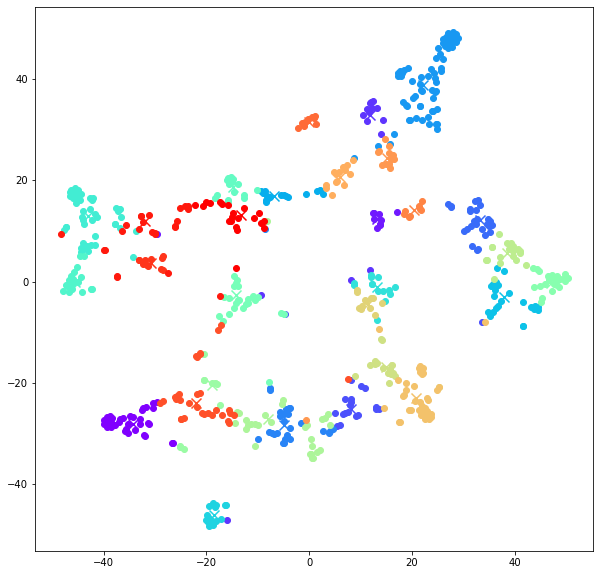

In [30]:
plt.figure(figsize=(10,10))
for ind, color in zip(clust_indices, colors):
    x = clusters[ind][:,0]
    y = clusters[ind][:,1]
    plt.scatter(x, y, color=color)
    
    centroid = centroids_embeddings[ind]
    plt.scatter(centroid[0],centroid[1], color=color, marker='x', s=100)

---

# Gensim Realization

In [31]:
id2word = corpora.Dictionary(voc)
texts = [test.split()]
corpus = [id2word.doc2bow(text) for text in texts]

In [32]:
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=10, 
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True,
    random_state=SEED
)

In [33]:
# Сохранение модели на диск
joblib.dump(lda_model, 'lda_model_gensim.pkl')

# Загрузка модели с диска
loaded_lda = joblib.load('lda_model_gensim.pkl')

In [34]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
3     -0.138214 -0.0       1        1  99.994844
9      0.015948 -0.0       2        1   0.000630
7      0.015876 -0.0       3        1   0.000619
1      0.015813  0.0       4        1   0.000610
4      0.015646  0.0       5        1   0.000591
5      0.015597  0.0       6        1   0.000586
8      0.015210 -0.0       7        1   0.000554
2      0.014854  0.0       8        1   0.000531
0      0.014649 -0.0       9        1   0.000518
6      0.014622  0.0      10        1   0.000517, topic_info=             Term          Freq      Total Category  logprob  loglift
5551        почва  4.500000e+01  45.000000  Default  30.0000  30.0000
4369  загрязнение  2.600000e+01  26.000000  Default  29.0000  29.0000
200         нефть  2.400000e+01  24.000000  Default  28.0000  28.0000
1025    природный  1.600000e+01  16.000000  Default  27.0000  27.0000
201      нефтяной  1.700000e+01  17.000000  Default  26.0000  26.0000
...           ...           ...        ...      ...      ...      ...
1088    состояние  5.045548e-07   6.713294  Topic10 -10.3144  -4.2309
908     компонент  4.984604e-07   7.158146  Topic10 -10.3265  -4.3072
3850       ун-тот  4.998292e-07   8.050032  Topic10 -10.3238  -4.4219
1649     миграция  4.959198e-07   6.270239  Topic10 -10.3316  -4.1799
1623     источник  4.976767e-07   7.158235  Topic10 -10.3281  -4.3088

[604 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
7843       1  1.030400     аккумуляция
41         1  0.959611         высокий
11764      1  0.959466       география
5597       1  0.957263   геохимический
80         1  0.956920          добыча
4369       1  0.989661     загрязнение
105        1  0.978223            зона
1623       1  0.977895        источник
131        1  1.034187           карта
908        1  0.977907       компонент
8793       1  0.960146        ландшафт
1649       1  0.956901        миграция
20910      1  1.042493            моск
2341       1  0.960292    нефтепродукт
200        1  0.979850           нефть
201        1  1.009530        нефтяной
202        1  1.030441          низкий
964        1  1.042644      окружающий
12221      1  1.030374           ореол
35234      1  0.929723       пиковский
5549       1  1.018158       поллютант
292        1  0.957441           поток
5551       1  0.991198           почва
7497       1  1.017744       почвенный
1025       1  0.997426       природный
337        1  0.957248         процесс
346        1  1.007268       различный
349        1  0.959855           район
7216       1  1.042720    самоочищение
1939       1  0.942324            сера
1088       1  1.042707       состояние
1089       1  1.003274           среда
4190       1  0.986019      территория
2445       1  1.034375     техногенный
1106       1  1.003544     углеводород
1107       1  0.942294  углеводородный
3850       1  0.993785          ун-тот
426        1  1.042649         условие
806        1  1.007204    устойчивость
1124       1  0.890860          фактор
2855       1  0.994282   экологический, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 10, 8, 2, 5, 6, 9, 3, 1, 7])